In [1]:
# test access to recent pubmed data on the new hardware
#   how are the speeds looking?

In [2]:
import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

import time
import hdbscan

In [3]:
db_name = 'test_pubmed'  # db name collisons? https://stackoverflow.com/questions/14011968/user-cant-access-a-database

#output_path = '/project2/jevans/brendan/pubmed_data_processing/year_pmids/'

########################
## load pre-fit pca models (fit using samples (size=100k) from the full corpus)

#pca_path = '/project2/jevans/brendan/pubmed_data_processing/dimensionality_reduction_models/pca_models/pca_model0.pkl'  # more located at /project2...
#with open(pca_path, 'rb') as file:
#    pca_model = pickle.load(file)
    
#########################
## control params

year = 2018
path2dir = '/home/brendan/FastData/pubmed2019/pubmed_data_processing/year_pmids/'  # knowledge-garden
#path2dir = '/project2/jevans/brendan/pubmed_data_processing/year_pmids/'  # RCC Midway2

In [4]:
config_path = '/home/brendan/Projects/AttentionWildfires/attention_wildfires/mysql_config.json'

with open(config_path, 'r') as f:
    config_data = json.load(f)
    
client_config = {'database': db_name,
                'user': config_data['user'],
                 'password': config_data['lock']}


In [5]:
# load the pre-fit umap model  (trained on time-flattened data)

print('pop open pickle jar: umap model...')
umap_path = "/home/brendan/FastData/pubmed2019/pubmed_data_processing/dimensionality_reduction_models/umap2D/umap_model0.pkl"
with open(umap_path, 'rb') as file:
    umap_model = pickle.load(file)

pop open pickle jar: umap model...


In [6]:
## test db connection

In [7]:
db = pymysql.connect(**client_config)


In [8]:
## how many pmids?

In [9]:
filename = 'pubmed_state_{}'.format(year)
path2pmids = path2dir + filename
with open(path2pmids,'r') as f:
    data = json.load(f)

year_pub_pmids = data['publications']
N_pubs = len(year_pub_pmids)
print("N pubs: {}".format(N_pubs))
del data # clean up



N pubs: 1205220


In [10]:
# take some samples from this year

In [11]:
K_sample = 2000
N_samplesets = 2
samples = {}
for i in range(N_samplesets):
    samples[i] = {}
    samples[i]['pmids'] = np.random.choice(year_pub_pmids, K_sample)

In [12]:
# helper function for selecting the embedding vectors

In [13]:
def get_embedding_vectors(sample_pmids):
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])

    sql = '''SELECT E.pmid, E.embedding
            FROM scibert_mean_embedding as E
            WHERE E.pmid IN ({})'''.format(str_fmt)

    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL join executed in {} s".format(elapsed))
    
    start_time = time.time()
    pub_embeddings = []
    pub_pmids = []
    for i,row in enumerate(cursor):
        print_block_len = 100000
        if (i+1) % print_block_len == 0:
            print('fetched {} rows...'.format(print_block_len))
        pub_pmids.append(row[0])
        pub_embeddings.append(np.frombuffer(row[1],dtype='float16').tolist())
    cursor.close()
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL results fetched and cast in {} s".format(elapsed))
    
    return pub_pmids, pub_embeddings

In [14]:
# populate embedding vectors for these samples

In [15]:
for i in range(N_samplesets):
    pmids, embeddings = get_embedding_vectors(samples[i]['pmids'])
    samples[i]['pmids'] = pmids  # remove pmids with no corresponding embedding (e.g. no abstract)
    samples[i]['raw_coordinates'] = embeddings
    print('compressing...')
    samples[i]['umap2D'] = umap_model.transform(embeddings)

SQL join executed in 0.20980286598205566 s
SQL results fetched and cast in 0.04469919204711914 s
compressing...


/home/brendan/anaconda3/envs/embedding-base/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../brendanchambers/.conda/envs/embedding-base/lib/python3.7/site-packages/umap/nndescent.py", line 123:
<source missing, REPL/exec in use?>

  state.func_ir.loc))
/home/brendan/anaconda3/envs/embedding-base/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../brendanchambers/.conda/envs/embedding-

SQL join executed in 0.21145129203796387 s
SQL results fetched and cast in 0.04025077819824219 s
compressing...


Text(0.5, 1.0, 'published: year 2018')

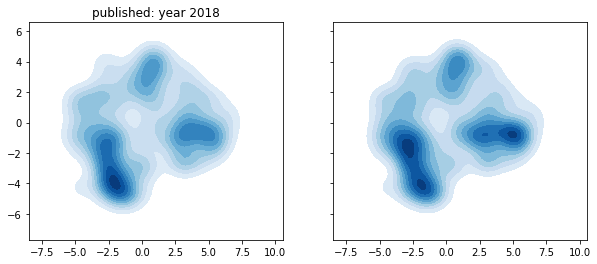

In [16]:
# sanity check - compare umap plots of the two samples

(f, ax) = plt.subplots(1,
                       2,
                       sharex='all', sharey='all',
                       figsize=(10,4))

sns.kdeplot(samples[0]['umap2D'][:,0], # these are pca'd
            samples[0]['umap2D'][:,1],
            ax=ax[0],
            shade=True,
    shade_lowest=False,
            cmap='Blues')
ax[0].set_title('published: year {}'.format(year))

sns.kdeplot(samples[1]['umap2D'][:,0], # these are pca'd
            samples[1]['umap2D'][:,1],
            ax=ax[1],
            shade=True,
    shade_lowest=False,
            cmap='Blues')
ax[0].set_title('published: year {}'.format(year))

## experiment with hdbscan

In [17]:
# compare clustering results across the two samples

num clusters: 3


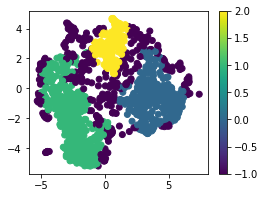

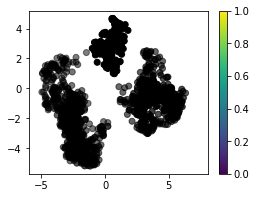

num clusters: 3


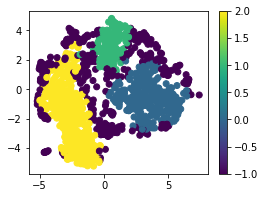

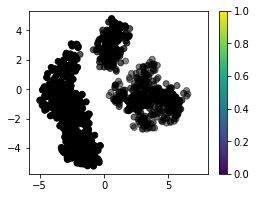

In [18]:
clusterers = {}
for i in range(N_samplesets):
    clusterers[i] = hdbscan.HDBSCAN(min_cluster_size=50,  # 50
                            min_samples=50,   # 100
                            cluster_selection_method='leaf')  # euclidean distance
    clusterers[i].fit(samples[i]['umap2D'])  # samples x features

    # number of clusters
    print('num clusters: {}'.format(clusterers[i].labels_.max()+1))
    
    # plot clusters
    plt.figure(figsize=(4,3))
    plt.scatter(samples[i]['umap2D'][:,0],
               samples[i]['umap2D'][:,1],
               c=clusterers[i].labels_)
    plt.colorbar()
    plt.show()

    # plot clusters using probabilities_ estimate  (todo combine plots)
    rgba = np.zeros( (np.shape(samples[i]['umap2D'])[0], 4) )
    rgba[:,3] = clusterers[i].probabilities_
    plt.figure(figsize=(4,3))
    plt.scatter(samples[i]['umap2D'][:,0],
               samples[i]['umap2D'][:,1],
               c=rgba)
    plt.colorbar()
    plt.show()


In [19]:
#  test exporting the clusters

pmids = {}  # for export
summary_coords = {}
for i_sample in range(N_samplesets):
    print("sample {}".format(i_sample))
    
    pmids[i_sample] = {}   # for export
    summary_coords[i_sample] = {}
    
    sample_pmids = np.array(samples[i_sample]['pmids'])  # for convenience, cast list -> np array
    sample_coords = np.array(samples[i_sample]['umap2D'])
    
    k_clusters = clusterers[i_sample].labels_.max() + 1
    for i_cluster in range(k_clusters):
              
        cluster_pmids = sample_pmids[clusterers[i_sample].labels_ == i_cluster]    
        cluster_coords = sample_coords[clusterers[i_sample].labels_ == i_cluster]
        print(np.shape(cluster_coords))
        
        pmids[i_sample][i_cluster] = cluster_pmids.tolist()   # format for export
        summary_coords[i_sample][i_cluster] = cluster_coords.tolist()
                

sample 0
(398, 2)
(577, 2)
(185, 2)
sample 1
(427, 2)
(184, 2)
(569, 2)


In [20]:
target_file = 'data_processing/test_clusters2018.json'

save_obj = {'pmids': pmids,
            'summary_coords': summary_coords}

with open(target_file,'w') as f:
    json.dump(save_obj, f)
